# Investigating the DepMap data

In [1]:
import pandas as pd
import numpy as np
import os

import MScausality.data_analysis.gene_set as gs
from MScausality.graph_construction.indra_networks import analysis_uniprot
from MScausality.graph_construction.graph import GraphBuilder
from MScausality.causal_model.LVM import LVM

from indra_cogex.client import Neo4jClient

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from dotenv import load_dotenv 
load_dotenv()

np.random.seed(0)

/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kohler.d/opt/anaconda3/envs/MScausality/lib/python3.11/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'underscore_attrs_are_private' has been removed
  warnings.warn(message, UserWarning)


In [2]:
df = pd.read_csv("../../data/depmap/Proteomics.csv", index_col=0)


In [3]:
def combine_duplicate_genes(data):

    # Get duplicate genes
    gene_names = data.columns.str.split().str[0]
    u, c = np.unique(gene_names, return_counts=True)
    dup = u[c > 1]

    remove = list()
    for i in dup:
        data.loc[:, "{} (full)".format(i)] = data.loc[:, data.columns.str.contains(i)].mean(axis=1)
        # remove = [i for i in list(data.columns.str.contains(i)) if "full" not in i]
        remove.extend([x for x in data.columns[data.columns.str.contains(i)] if "full" not in x])
    data = data.loc[:, ~df.columns.isin(remove)]
    return data
    
df = combine_duplicate_genes(df)
df.columns = df.columns.str.split().str[0]

print(len(df.columns))
print(len(df.columns.unique()))

/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_74585/1900951203.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, "{} (full)".format(i)] = data.loc[:, data.columns.str.contains(i)].mean(axis=1)
/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_74585/1900951203.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, "{} (full)".format(i)] = data.loc[:, data.columns.str.contains(i)].mean(axis=1)
/var/folders/v7/y32f7x653v9cx3jmt128bnhh0000gp/T/ipykernel_74585/1900951203.py:10: Performan

12074
12074


## General data analaysis

### Overview

#### Experimental design

42 10-plex TMT mixtures, 9 biological and 1 bridge (normalization) channel.

375 cell lines

12 fractions quantified with MS3 (I think this is why they get such high converage).

No raw id/quant data :,(

Normalization was done by global median within plex and normalization channels across plex

In [34]:
print("Number of proteins: {0}".format(len(df.columns)))
print("Number of samples: {0}".format(len(df)))

Number of proteins: 12074
Number of samples: 375


### Correlations

In [5]:
corr_data = gs.gen_correlation_matrix(df, methods=["pearson"], abs_corr=True)

Correlation matrix for pearson:


Text(0, 0.5, 'Frequency')

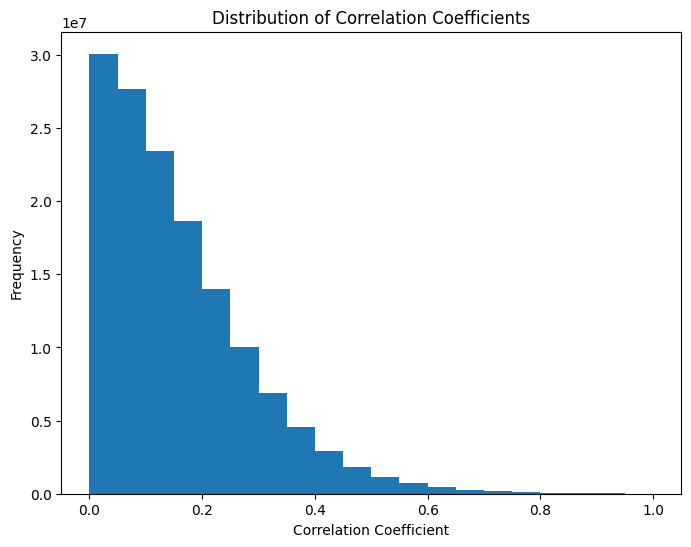

In [6]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(corr_data['pearson']['value'], bins=20)

ax.set_title("Distribution of Correlation Coefficients")
ax.set_xlabel("Correlation Coefficient")
ax.set_ylabel("Frequency")

### Missing values

Text(0, 0.5, 'Frequency')

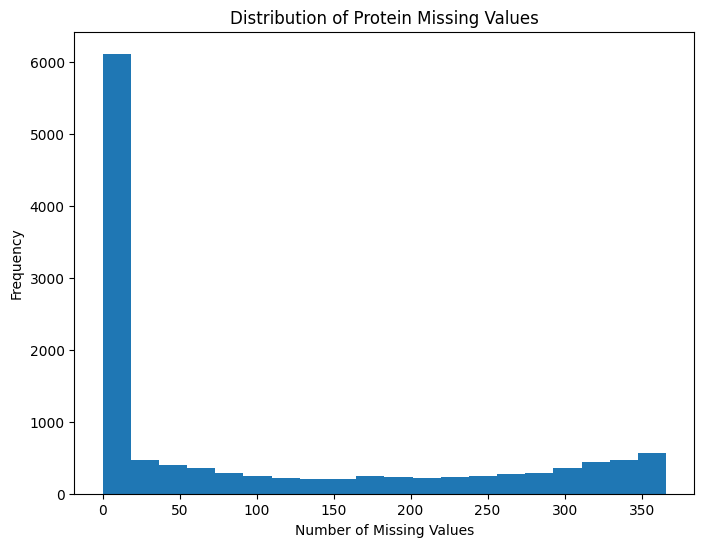

In [7]:
missing_values = df.isna().sum()

# Plot missing values in histogram
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(missing_values, bins=20)
ax.set_title("Distribution of Protein Missing Values")
ax.set_xlabel("Number of Missing Values")
ax.set_ylabel("Frequency")


Text(0, 0.5, 'Frequency')

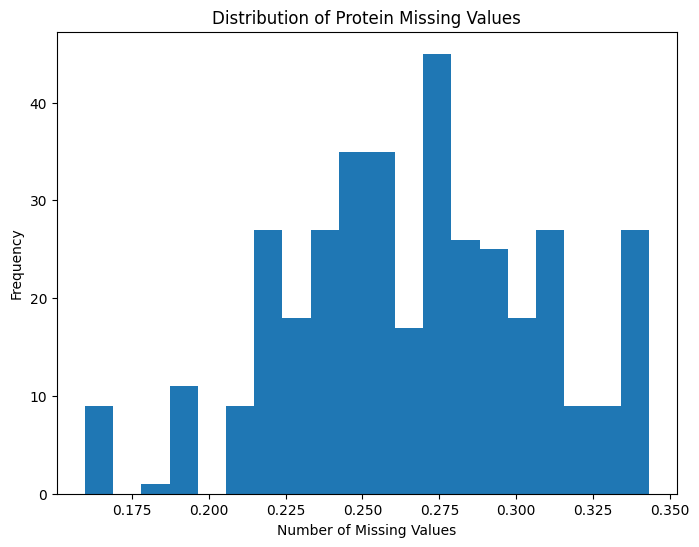

In [8]:
missing_values = df.isna().sum(axis=1) / len(df.columns)

# Plot missing values in histogram
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(missing_values, bins=20)
ax.set_title("Distribution of Protein Missing Values")
ax.set_xlabel("Number of Missing Values")
ax.set_ylabel("Frequency")

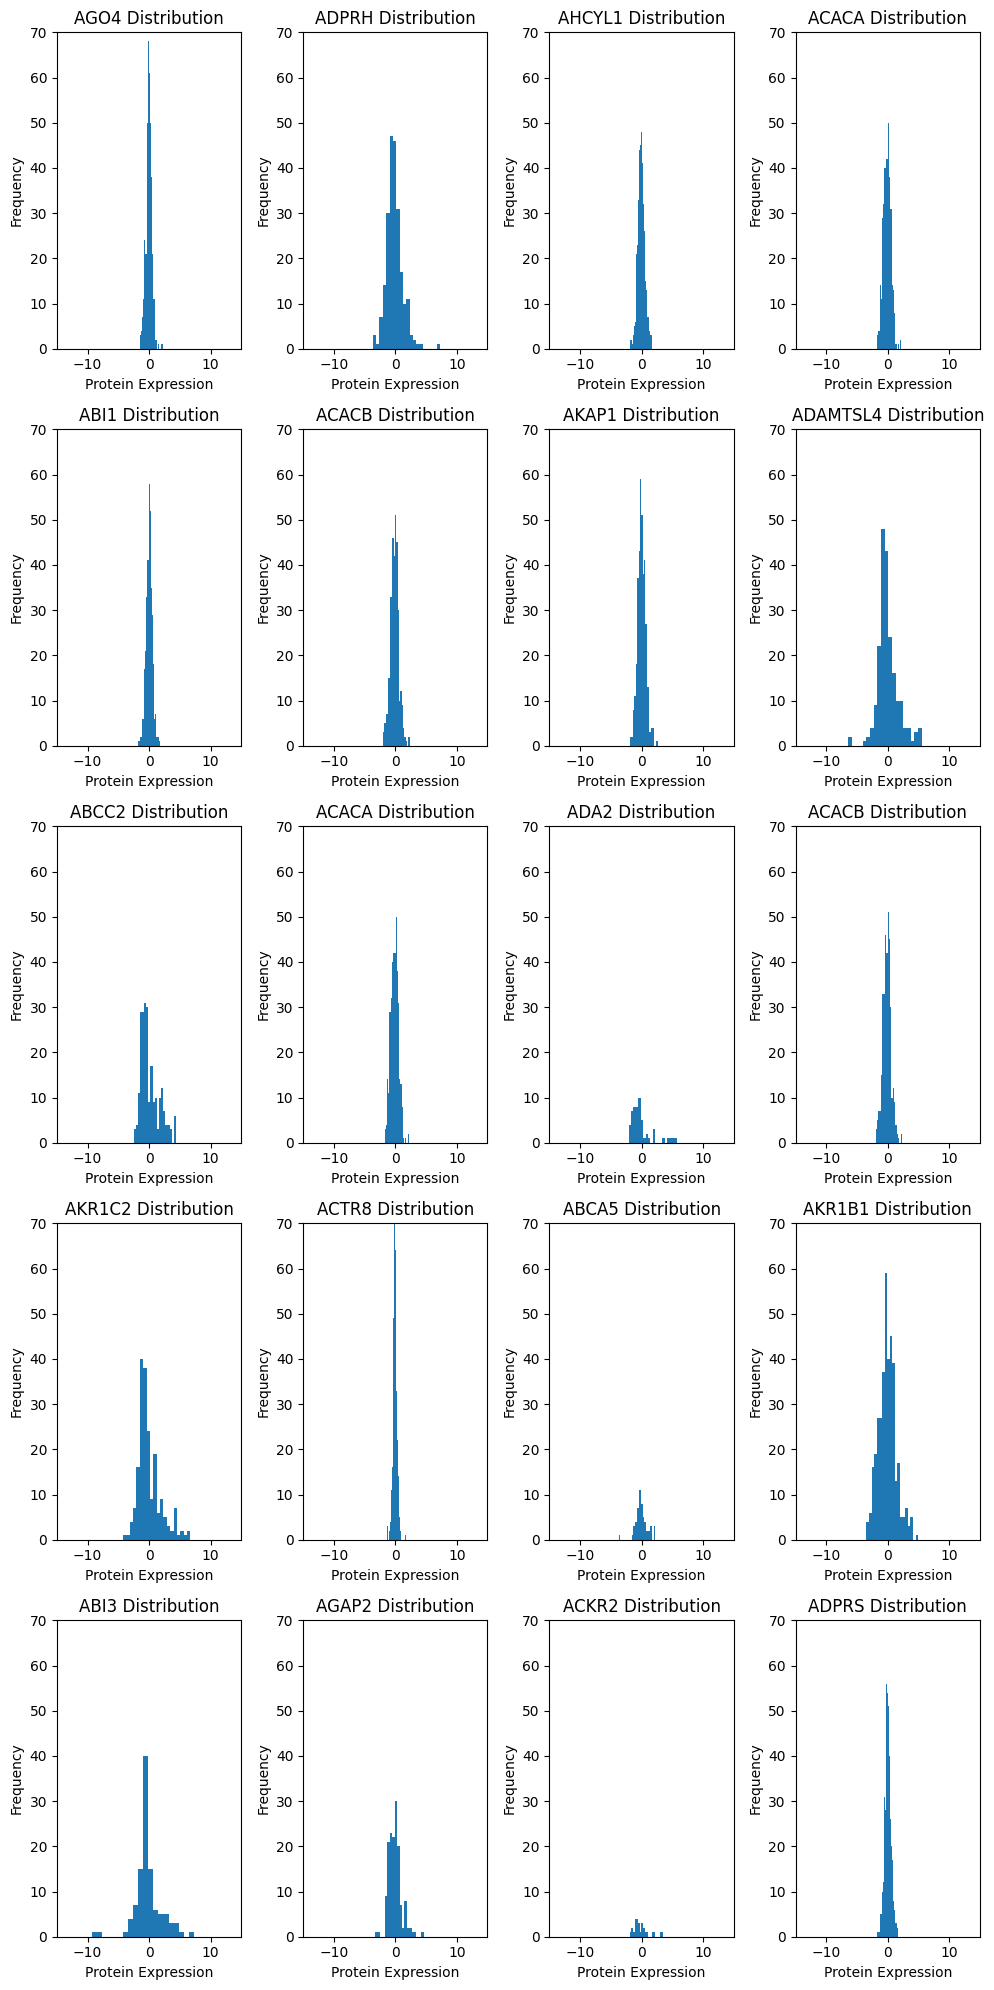

In [9]:
df.iloc[:, np.random.randint(0, len(df), 10)]

fig, ax = plt.subplots(5,4, figsize=(10, 20))

for i in range(5):
    for j in range(4):
        protein = np.random.randint(0, len(df), 1)
        ax[i,j].hist(df.iloc[:, protein].values, bins=20)
        ax[i,j].set_title("{0} Distribution".format(df.columns.values[protein][0]))
        ax[i,j].set_xlabel("Protein Expression")
        ax[i,j].set_ylabel("Frequency")
        # Spread out subplots
        plt.tight_layout()

        ax[i,j].set_ylim(0,70)
        ax[i,j].set_xlim(-15,15)

## Pathway analysis

### Regulatory pathways

In [ ]:
regulatory_paths = gs.test_gene_sets(corr_data, df.columns, "../../data/gene_sets/regulatory_pathways.json", threshold=0.33)

AAANWWTGC_UNKNOWN
AAAYRNCTG_UNKNOWN
AAAYWAACM_HFH4_01
AACTTT_UNKNOWN
AACWWCAANK_UNKNOWN
AACYNNNNTTCCS_UNKNOWN
AAGWWRNYGGC_UNKNOWN
ACAWNRNSRCGG_UNKNOWN
ACAWYAAAG_UNKNOWN
ACCTGTTG_UNKNOWN
ACTAYRNNNCCCR_UNKNOWN
ACTWSNACTNY_UNKNOWN
ADA2_TARGET_GENES
ADCYAP1_TARGET_GENES
ADNP_TARGET_GENES
AEBP2_TARGET_GENES
AFP1_Q6
AGCYRWTTC_UNKNOWN
AHR_01
AHR_Q5
AHRARNT_01
AHRARNT_02
AHRR_TARGET_GENES
ALKBH3_TARGET_GENES
ALPHACP1_01
ALX4_01
ALX4_TARGET_GENES
AMEF2_Q6
AML1_01
AML1_Q6
AML_Q6
AP1_01
AP1_C
AP1_Q2
AP1_Q2_01
AP1_Q4
AP1_Q4_01
AP1_Q6
AP1_Q6_01
AP1FJ_Q2
AP2_Q3
AP2_Q6
AP2_Q6_01
AP2ALPHA_01
AP2GAMMA_01
AP2REP_01
AP3_Q6
AP4_01
AP4_Q5
AP4_Q6
AP4_Q6_01
AR_01
AR_02
AR_03
AR_Q2
AR_Q6
AREB6_01
AREB6_02
AREB6_03
AREB6_04
ARGGGTTAA_UNKNOWN
ARHGAP35_TARGET_GENES
ARID3B_TARGET_GENES
ARID5B_TARGET_GENES
ARNT2_TARGET_GENES
ARNT_01
ARNT_02
ARP1_01
ASH1L_TARGET_GENES
ASXL2_TARGET_GENES
ATCMNTCCGY_UNKNOWN
ATF1_Q6
ATF3_Q6
ATF4_Q2
ATF5_TARGET_GENES
ATF6_01
ATF6_TARGET_GENES
ATF_01
ATF_B
ATGGYGGA_UNKNOWN
ATM_TARGET_GE

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
0,AAANWWTGC_UNKNOWN,pearson,195,146,0.748718,10585,"MYLK 910 MYLK 911 Name: FGFR2, dtype: int64","MYLK 0.085971 MYLK 0.086065 Name: FGFR2,..."
1,AAAYRNCTG_UNKNOWN,pearson,375,261,0.696000,33930,"MAP2 2700 MAP2 2696 Name: ZNF687, dtype:...",MAP2 0.079576 MAP2 0.079458 Name: ZNF687...
2,AAAYWAACM_HFH4_01,pearson,262,183,0.698473,16653,"ITGA3 1449 ITGA3 1450 Name: DNAJB12, dty...",ITGA3 0.087011 ITGA3 0.087071 Name: DNAJ...
3,AACTTT_UNKNOWN,pearson,1928,1376,0.713693,946000,"ITSN1 83317 ITSN1 83363 Name: ETV5, dtyp...",ITSN1 0.088073 ITSN1 0.088122 Name: ETV5...
4,AACWWCAANK_UNKNOWN,pearson,146,119,0.815068,7021,"PNKD 705 PNKD 706 Name: SNAPC3, dtype: i...",PNKD 0.100413 PNKD 0.100555 Name: SNAPC3...
...,...,...,...,...,...,...,...,...
1110,ZSCAN4_TARGET_GENES,pearson,1458,862,0.591221,371091,"FAHD1 34909 FAHD1 34857 Name: PFKL, dtyp...",FAHD1 0.094071 FAHD1 0.093931 Name: PFKL...
1111,ZSCAN5B_TARGET_GENES,pearson,85,41,0.482353,820,"SMARCC2 105 SMARCC2 104 Name: LASP1, dty...",SMARCC2 0.128049 SMARCC2 0.126829 Name: ...
1112,ZSCAN5C_TARGET_GENES,pearson,152,104,0.684211,5356,"MYLK 479 MYLK 473 Name: TRIP4, dtype: int64","MYLK 0.089432 MYLK 0.088312 Name: TRIP4,..."
1113,ZSCAN5DP_TARGET_GENES,pearson,1533,1082,0.705806,584821,"FAHD1 66763 FAHD1 66718 Name: SENP5, dty...",FAHD1 0.114160 FAHD1 0.114083 Name: SENP...


In [35]:
# regulatory_paths.to_csv("../../data/depmap/regulatory_paths_depmap_corr.csv", index=False)
regulatory_paths = pd.read_csv("../../data/depmap/regulatory_paths_depmap_corr.csv")

In [36]:
regulatory_paths.sort_values("percent", ascending=False).head()

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
795,STN1_TARGET_GENES,pearson,11,7,0.636364,21,11,0.523810
161,COIL_TARGET_GENES,pearson,8,4,0.500000,6,3,0.500000
685,REPIN1_TARGET_GENES,pearson,5,4,0.800000,6,3,0.500000
978,ZNF19_TARGET_GENES,pearson,13,10,0.769231,45,20,0.444444
638,PER1_TARGET_GENES,pearson,33,19,0.575758,171,71,0.415205


In [27]:
brd2_sets = gs.find_sets_with_gene(["BRD2"], "../../data/gene_sets/regulatory_pathways.json")
brd3_sets = gs.find_sets_with_gene(["BRD3"], "../../data/gene_sets/regulatory_pathways.json")
brd4_sets = gs.find_sets_with_gene(["BRD4"], "../../data/gene_sets/regulatory_pathways.json")
brd_sets = gs.find_sets_with_gene(["BRD2", "BRD3", "BRD4"], "../../data/gene_sets/regulatory_pathways.json")
men1_sets = gs.find_sets_with_gene(["MEN1"], "../../data/gene_sets/regulatory_pathways.json")

In [28]:
regulatory_paths[(regulatory_paths["pathway"].isin(brd2_sets)) & 
                 (regulatory_paths["total_genes"] < 20)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
490,MDM2_TARGET_GENES,pearson,13,10,0.769231,45,5,0.111111
980,ZNF20_TARGET_GENES,pearson,6,5,0.833333,10,0,0.000000


In [29]:
regulatory_paths[regulatory_paths["pathway"].isin(brd3_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
447,KAT2A_TARGET_GENES,pearson,1166,872,0.747856,379756,49865,0.131308
558,NFMUE1_Q6,pearson,250,217,0.868000,23436,3063,0.130696
486,MCM2_TARGET_GENES,pearson,88,71,0.806818,2485,306,0.123139
146,CEBPZ_TARGET_GENES,pearson,1543,1151,0.745949,661825,80012,0.120896
63,ARID5B_TARGET_GENES,pearson,943,670,0.710498,224115,27016,0.120545
539,NCOA4_TARGET_GENES,pearson,1100,772,0.701818,297606,32741,0.110015
227,E2F5_TARGET_GENES,pearson,1289,891,0.691234,396495,42985,0.108412
451,KLF14_TARGET_GENES,pearson,257,172,0.669261,14706,1586,0.107847
499,MEF2D_TARGET_GENES,pearson,659,424,0.643399,89676,9573,0.106751
1101,ZNF8_TARGET_GENES,pearson,1055,707,0.670142,249571,26081,0.104503


In [34]:
regulatory_paths[regulatory_paths["pathway"].isin(brd4_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
1083,ZNF711_TARGET_GENES,pearson,1762,1300,0.737798,844350,105059,0.124426
272,EWSR1_TARGET_GENES,pearson,1039,693,0.666987,239778,27363,0.114118
227,E2F5_TARGET_GENES,pearson,1289,891,0.691234,396495,42985,0.108412
812,TAL1BETAITF2_01,pearson,266,179,0.672932,15931,1715,0.107652
811,TAL1BETAE47_01,pearson,255,168,0.658824,14028,1505,0.107285
296,FOXO4_TARGET_GENES,pearson,387,275,0.710594,37675,3995,0.106038
998,ZNF2_TARGET_GENES,pearson,1205,837,0.694606,349866,36929,0.105552
322,GCANCTGNY_MYOD_Q6,pearson,936,655,0.699786,214185,22504,0.105068
676,RAG1_TARGET_GENES,pearson,1206,826,0.684909,340725,35545,0.104322
1002,ZNF320_TARGET_GENES,pearson,1603,1032,0.643793,531996,55381,0.104100


In [51]:
regulatory_paths[regulatory_paths["pathway"].isin(brd_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent


In [52]:
regulatory_paths[regulatory_paths["pathway"].isin(men1_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
868,TNCATNTCCYR_UNKNOWN,pearson,137,107,0.781022,5671,775,0.136660
200,DIDO1_TARGET_GENES,pearson,1642,1254,0.763703,785631,104138,0.132553
1058,ZNF581_TARGET_GENES,pearson,334,249,0.745509,30876,4086,0.132336
669,PTPRA_TARGET_GENES,pearson,130,76,0.584615,2850,362,0.127018
721,SALL4_TARGET_GENES,pearson,1870,1321,0.706417,871860,94583,0.108484
321,GATTGGY_NFY_Q6_01,pearson,1177,919,0.780799,421821,44052,0.104433
341,GGGTGGRR_PAX4_03,pearson,1310,968,0.738931,468028,47490,0.101468
944,ZBTB5_TARGET_GENES,pearson,517,339,0.655706,57291,5765,0.100627
358,GTGGGTGK_UNKNOWN,pearson,298,207,0.694631,21321,2134,0.100089
1015,ZNF394_TARGET_GENES,pearson,1129,742,0.657219,274911,26520,0.096468


### Hallmark pathways

In [54]:
# hallmark_paths = gs.test_gene_sets(corr_data, df.columns, "../../data/gene_sets/hallmark_pathways.json", threshold=0.33)
# hallmark_paths.to_csv("../../data/depmap/hallmark_paths_depmap_corr.csv", index=False)

hallmark_paths = pd.read_csv("../../data/depmap/hallmark_paths_depmap_corr.csv")
hallmark_paths.sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
31,HALLMARK_MYC_TARGETS_V1,pearson,200,195,0.975000,18915,5243,0.277187
35,HALLMARK_OXIDATIVE_PHOSPHORYLATION,pearson,200,188,0.940000,17578,4762,0.270907
32,HALLMARK_MYC_TARGETS_V2,pearson,58,56,0.965517,1540,415,0.269481
12,HALLMARK_E2F_TARGETS,pearson,200,191,0.955000,18145,4731,0.260733
25,HALLMARK_INTERFERON_ALPHA_RESPONSE,pearson,97,85,0.876289,3570,831,0.232773
37,HALLMARK_PANCREAS_BETA_CELLS,pearson,40,31,0.775000,465,104,0.223656
17,HALLMARK_G2M_CHECKPOINT,pearson,200,189,0.945000,17766,3606,0.202972
40,HALLMARK_PROTEIN_SECRETION,pearson,96,93,0.968750,4278,860,0.201029
13,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,pearson,200,178,0.890000,15753,3002,0.190567
39,HALLMARK_PI3K_AKT_MTOR_SIGNALING,pearson,105,87,0.828571,3741,665,0.177760


In [55]:
brd2_sets = gs.find_sets_with_gene(["BRD2"], "../../data/gene_sets/hallmark_pathways.json")
brd3_sets = gs.find_sets_with_gene(["BRD3"], "../../data/gene_sets/hallmark_pathways.json")
brd4_sets = gs.find_sets_with_gene(["BRD4"], "../../data/gene_sets/hallmark_pathways.json")
brd_sets = gs.find_sets_with_gene(["BRD2", "BRD3", "BRD4"], "../../data/gene_sets/regulatory_pathways.json")
men1_sets = gs.find_sets_with_gene(["MEN1"], "../../data/gene_sets/hallmark_pathways.json")

In [56]:
hallmark_paths[hallmark_paths["pathway"].isin(brd2_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent


In [57]:
hallmark_paths[hallmark_paths["pathway"].isin(brd3_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent


In [58]:
hallmark_paths[hallmark_paths["pathway"].isin(brd4_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent


In [59]:
hallmark_paths[hallmark_paths["pathway"].isin(men1_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent


### Cancer pathways

In [123]:
cancer_paths = gs.test_gene_sets(corr_data, "../../data/gene_sets/cancer_pathways.json", threshold=0.33)
cancer_paths.head()

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
0,GAVISH_3CA_MALIGNANT_METAPROGRAM_1_CELL_CYCLE_...,pearson,50,26,0.52,325,93,0.286154
1,GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_...,pearson,50,23,0.46,253,127,0.501976
2,GAVISH_3CA_MALIGNANT_METAPROGRAM_3_CELL_CYLCE_...,pearson,50,14,0.28,91,47,0.516484
3,GAVISH_3CA_MALIGNANT_METAPROGRAM_4_CHROMATIN,pearson,50,21,0.42,210,46,0.219048
4,GAVISH_3CA_MALIGNANT_METAPROGRAM_5_STRESS,pearson,50,4,0.08,6,1,0.166667


In [124]:
brd2_sets = gs.find_sets_with_gene(["BRD2"], "../../data/gene_sets/cancer_pathways.json")
brd3_sets = gs.find_sets_with_gene(["BRD3"], "../../data/gene_sets/cancer_pathways.json")
brd4_sets = gs.find_sets_with_gene(["BRD4"], "../../data/gene_sets/cancer_pathways.json")
brd_sets = gs.find_sets_with_gene(["BRD2", "BRD3"], "../../data/gene_sets/cancer_pathways.json")
men1_sets = gs.find_sets_with_gene(["MEN1"], "../../data/gene_sets/cancer_pathways.json")

In [94]:
cancer_paths[cancer_paths["pathway"].isin(brd2_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
83,GAVISH_3CA_METAPROGRAM_FIBROBLASTS_STRESS,pearson,50,7,0.140000,21,9,0.428571
576,MORF_CCNI,pearson,88,29,0.329545,406,164,0.403941
251,GCM_GSTA4,pearson,68,19,0.279412,171,63,0.368421
898,MODULE_198,pearson,303,129,0.425743,8256,2992,0.362403
628,MORF_EIF4A2,pearson,138,43,0.311594,903,311,0.344408
607,MORF_ACP1,pearson,211,82,0.388626,3321,1095,0.329720
664,MORF_UBE2I,pearson,238,74,0.310924,2701,872,0.322843
857,MODULE_98,pearson,393,159,0.404580,12561,4008,0.319083
68,GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_STRESS,pearson,50,8,0.160000,28,7,0.250000
286,GCM_MYST2,pearson,172,65,0.377907,2080,404,0.194231


In [95]:
cancer_paths[cancer_paths["pathway"].isin(brd3_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
628,MORF_EIF4A2,pearson,138,43,0.311594,903,311,0.344408
622,MORF_DDB1,pearson,246,95,0.386179,4465,1239,0.277492
621,MORF_DAP3,pearson,195,63,0.323077,1953,519,0.265745
642,MORF_PHB,pearson,125,48,0.384000,1128,297,0.263298
649,MORF_PRKAG1,pearson,224,79,0.352679,3081,790,0.256410
657,MORF_RAF1,pearson,111,39,0.351351,741,187,0.252362
602,MORF_TERF2IP,pearson,116,42,0.362069,861,210,0.243902
617,MORF_CSNK1D,pearson,71,28,0.394366,378,88,0.232804
241,MORF_TPR,pearson,147,59,0.401361,1711,372,0.217417
653,MORF_RAB1A,pearson,193,67,0.347150,2211,479,0.216644


In [96]:
cancer_paths[cancer_paths["pathway"].isin(brd4_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
819,MODULE_379,pearson,203,13,0.064039,78,22,0.282051
780,MODULE_16,pearson,508,109,0.214567,5886,1532,0.260279
779,MODULE_15,pearson,357,81,0.226891,3240,825,0.254630
784,MODULE_23,pearson,562,36,0.064057,630,158,0.250794
209,MORF_MAP2K7,pearson,181,14,0.077348,91,22,0.241758
789,MODULE_44,pearson,325,50,0.153846,1225,295,0.240816
810,MODULE_137,pearson,545,49,0.089908,1176,278,0.236395
194,MORF_IFNA1,pearson,205,16,0.078049,120,28,0.233333
170,MORF_ATF2,pearson,330,33,0.100000,528,121,0.229167
800,MODULE_88,pearson,834,60,0.071942,1770,402,0.227119


In [98]:
cancer_paths[cancer_paths["pathway"].isin(brd_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
628,MORF_EIF4A2,pearson,138,43,0.311594,903,311,0.344408


In [51]:
cancer_paths[cancer_paths["pathway"].isin(men1_sets)].sort_values("percent", ascending=False).head(10)

,pathway,correlation,total_genes,measured_genes,percent_measured,total_tests,sig_corrs,percent
681,GCM_TPR,pearson,32,14,0.437500,91,40,0.439560
667,GCM_HDAC1,pearson,38,16,0.421053,120,39,0.325000
596,MORF_RPA2,pearson,193,77,0.398964,2926,801,0.273753
785,MODULE_24,pearson,453,38,0.083885,703,189,0.268848
784,MODULE_23,pearson,562,36,0.064057,630,158,0.250794
773,MODULE_6,pearson,413,40,0.096852,780,193,0.247436
787,MODULE_38,pearson,463,51,0.110151,1275,288,0.225882
870,MODULE_123,pearson,247,63,0.255061,1953,435,0.222734
504,MODULE_430,pearson,55,16,0.290909,120,26,0.216667
375,MODULE_67,pearson,226,24,0.106195,276,43,0.155797


# Pull some networks from INDRA

In [4]:
tf_obs = gs.extract_genes_in_path(df.columns, "MDM2_TARGET_GENES", "../../data/gene_sets/regulatory_pathways.json", return_all=False)
tf_all = gs.extract_genes_in_path(df.columns, "MDM2_TARGET_GENES", "../../data/gene_sets/regulatory_pathways.json", return_all=True)

In [5]:
tf_obs

['ZBTB4',
 'FTL',
 'BRD2',
 'HEXIM1',
 'SNX12',
 'FUS',
 'ADM',
 'POLR2A',
 'INTS6',
 'KMT2A']

In [6]:
client = Neo4jClient(url=os.getenv("API_URL"), 
                        auth=(os.getenv("USER"), 
                            os.getenv("PASSWORD"))
                    )

In [7]:
set = "MDM2_TARGET_GENES"
ids = tf_obs
mdm2_obs_network = analysis_uniprot(
    ids=ids,
    analysis_id=set,
    client=client,
    minimum_evidence_count=1,
    id_type="gene"
)

mdm2_obs_network.to_csv(
    "../../data/INDRA_networks/depmap_networks/{0}.tsv".format(set),
    sep="\t",
    index=False)

9
0
1
2
3
4
5
6
7
8
0.0001289844512939453
2
MATCH p=(n1:BioEntity)<-[r1:indra_rel]-(n3:BioEntity)-[r2:indra_rel]->(n2:BioEntity)
WHERE
    n1.id IN ['hgnc:23847', 'hgnc:4010', 'hgnc:14976', 'hgnc:1103', 'hgnc:7132', 'hgnc:9187', 'hgnc:24953', 'hgnc:259', 'hgnc:3999', 'hgnc:14879']
    AND n2.id IN ['hgnc:23847', 'hgnc:4010', 'hgnc:14976', 'hgnc:1103', 'hgnc:7132', 'hgnc:9187', 'hgnc:24953', 'hgnc:259', 'hgnc:3999', 'hgnc:14879']
    AND n1.id <> n2.id
    AND NOT n3.id IN ['hgnc:23847', 'hgnc:4010', 'hgnc:14976', 'hgnc:1103', 'hgnc:7132', 'hgnc:9187', 'hgnc:24953', 'hgnc:259', 'hgnc:3999', 'hgnc:14879']
    AND n3.type = "human_gene_protein"
    AND r1.stmt_type IN ['IncreaseAmount', 'DecreaseAmount']
    AND r2.stmt_type IN ['IncreaseAmount', 'DecreaseAmount']
RETURN p

844
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74

In [8]:
mdm2_obs_network

,source_hgnc_id,source_hgnc_symbol,relation,target_hgnc_id,target_hgnc_symbol,stmt_hash,evidence_count,source_counts,reason_added,source_observed,target_observed
1,1103,BRD2,IncreaseAmount,24953,HEXIM1,5587871255670217,1,"{""reach"": 1}",direct,True,True
0,9982,RFX1,DecreaseAmount,259,ADM,-29250679731577564,1,"{""biopax"": 1}",confounder,False,True
1,9982,RFX1,DecreaseAmount,1103,BRD2,-30204686287200776,1,"{""biopax"": 1}",confounder,False,True
2,9884,RB1,DecreaseAmount,9187,POLR2A,4300119308704103,2,"{""biopax"": 2}",confounder,False,True
3,9884,RB1,IncreaseAmount,1103,BRD2,-18629028319752340,1,"{""biopax"": 1}",confounder,False,True
...,...,...,...,...,...,...,...,...,...,...,...
363,5992,IL1B,DecreaseAmount,3999,FTL,-7145009128997047,1,"{""medscan"": 1}",mediator,False,True
364,259,ADM,DecreaseAmount,5992,IL1B,-2296800977247159,2,"{""reach"": 2}",mediator,True,False
366,259,ADM,IncreaseAmount,5992,IL1B,-33605033396837493,1,"{""reach"": 1}",mediator,True,False
371,5992,IL1B,IncreaseAmount,3999,FTL,16378513585837303,2,"{""medscan"": 2}",mediator,False,True


In [9]:
df.head()

,A1CF,A2M,A2ML1,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,XIRP2,YAP1,YBX3,ZC3H13,ZC3H14,ZC3HAV1,ZDHHC20,ZFP64,ZNF185,ZNF451
ACH-000001,NaN,0.285257,NaN,0.067878,-0.828192,NaN,-0.712768,-1.285871,0.881729,-0.230943,...,NaN,-0.283418,-0.178274,0.282163,0.447319,-0.467607,0.139089,0.881389,1.650171,0.679407
ACH-000004,NaN,-1.172647,NaN,-0.497486,-0.666285,NaN,0.258156,-0.844103,1.330403,1.554413,...,-0.084801,-1.320496,0.976353,0.384078,-0.204901,0.233657,-0.785551,-0.846301,-1.359443,-0.547130
ACH-000005,NaN,-1.697189,NaN,-0.239254,-0.546895,NaN,0.794643,-0.130001,0.875214,1.398722,...,NaN,-1.192627,1.805807,0.135630,-0.259184,0.403540,-0.244757,0.015441,-0.859146,-0.829171
ACH-000006,NaN,-1.106344,NaN,1.205109,0.660346,-0.349801,-0.539838,0.951283,0.139173,-0.211486,...,0.070225,-1.806485,-1.278601,-0.294775,-0.990503,0.387209,-0.737721,-0.960994,-1.674105,0.671044
ACH-000007,1.668669,-0.903152,NaN,-0.314867,0.095937,0.050824,-0.021503,-0.434812,-0.277156,-0.491505,...,NaN,0.380722,0.200843,-0.075786,-0.410993,-0.298811,0.899468,-0.235355,0.325304,-0.532642


Preparing experimental data...
Data already in wide format...
Preparing INDRA statements...
Building graph...
Fixing cycles...


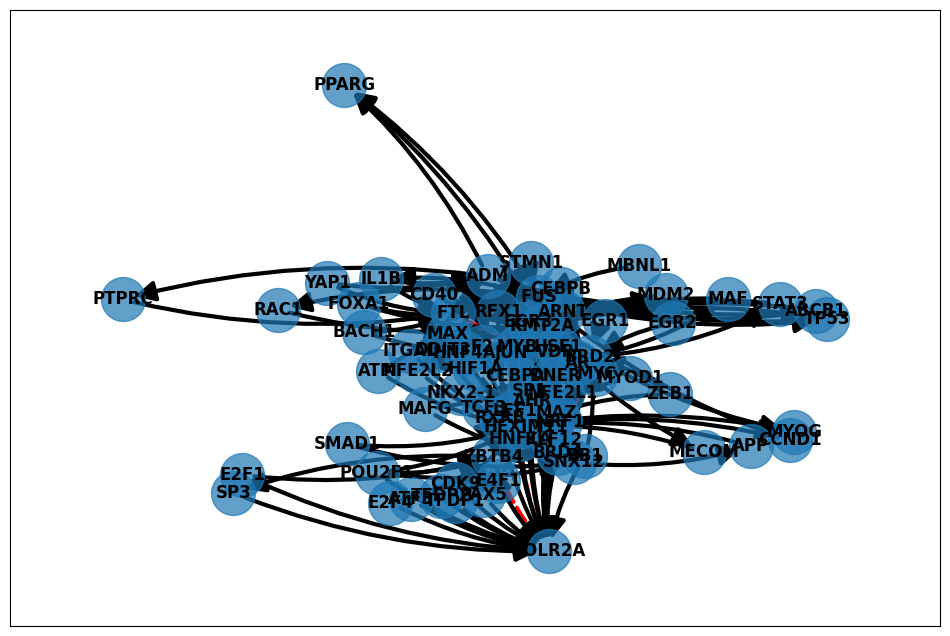

In [11]:
mdm2_dag = GraphBuilder(mdm2_obs_network, df, False)

mdm2_dag.build_full_graph(data_type="LF",
                        protein_format="Gene_Name_Organism",
                        source_name="source_hgnc_symbol",
                        target_name="target_hgnc_symbol")
mdm2_dag.build_dag()
mdm2_dag.create_latent_graph()
mdm2_dag.plot_latent_graph(figure_size=(12, 8))

In [30]:
mdm2_dag.causal_graph.directed.edges

OutEdgeView([(KMT2A, MECOM), (KMT2A, MYOG), (KMT2A, NFE2L2), (KMT2A, PPARG), (HNF4A, ADM), (HNF4A, HEXIM1), (E2F4, POLR2A), (E2F4, ZBTB4), (JUN, ADM), (JUN, BRD2), (JUN, HEXIM1), (EGR2, BRD2), (EGR2, FUS), (CEBPB, ADM), (CEBPB, KMT2A), (NFE2L1, BRD2), (NFE2L1, HEXIM1), (TP53, KMT2A), (CD40, KMT2A), (MAX, BRD2), (MAX, KMT2A), (ARNT, ADM), (ARNT, BRD2), (ARNT, KMT2A), (CDK9, HEXIM1), (CDK9, POLR2A), (ATM, FTL), (ATM, HEXIM1), (LEF1, FTL), (LEF1, FUS), (LEF1, HEXIM1), (LEF1, POLR2A), (LEF1, ZBTB4), (MYB, ADM), (MYB, HEXIM1), (MYB, KMT2A), (BRD2, HEXIM1), (BRD2, MAF), (BRD2, NFE2L2), (BRD2, STAT3), (BRD2, FTL), (BRD2, KMT2A), (CCND1, HEXIM1), (STMN1, FUS), (HNF1A, HEXIM1), (HNF1A, KMT2A), (HNF1A, POLR2A), (HNF1A, ZBTB4), (ATF3, POLR2A), (ATF3, ZBTB4), (TFDP2, POLR2A), (TFDP2, ZBTB4), (ITGAL, ADM), (ITGAL, HEXIM1), (E2F1, POLR2A), (E2F1, ZBTB4), (PTPRC, FTL), (HIF1A, ADM), (HIF1A, SNX12), (MAZ, BRD2), (MAZ, FUS), (MAZ, HEXIM1), (MAZ, KMT2A), (MAZ, POLR2A), (MAZ, SNX12), (MAZ, ZBTB4), (TCF3,

In [16]:
lvm = LVM(mdm2_dag.experimental_data.reset_index(drop=True), 
          mdm2_dag.causal_graph)
lvm.prepare_graph()
lvm.prepare_data()

lvm.fit_model()
#lvm.intervention("obs_Ras", "Erk", 3.)

starting training
92191.26317448064
21516.44907221198
1682.5027561699972
-6320.945848260075
-10913.348567983136
-13876.397250020877
-16073.089356318116
-17599.581198405474
-18693.87445813045
-19653.942760683596
-20502.59066160582
-20776.373622752726
-21373.394308190793
-21661.0836478509
-22172.273586746305
-22282.904572095722
-22268.254748655483
-22700.35545546189
-22779.85238751024
-22747.913551401347


In [18]:
lvm.parameters.sort_values("mean")

,parameter,mean,scale
80,DDIT3_scale,-1.385831,0.035417516
74,POLR2A_scale,-1.3710881,0.036467273
31,APP_scale,-1.3011105,0.036924172
156,BRD2_scale,-1.2116046,0.03536821
51,FUS_scale,-0.943666,0.03586203
...,...,...,...
193,MYOG_KMT2A_coef,0.6825376,0.12105855
197,NFE2L2_BRD2_coef,0.7002004,0.11280211
99,ADM_SP1_coef,0.740336,0.049943246
126,PTPRC_ADM_coef,0.79964864,0.046545923


# Use Talus networks

In [7]:
gene_set = "CCCNNNNNNAAGWT_UNKNOWN"
cnagwt = pd.read_csv(
    "../../data/INDRA_networks/Talus_networks/{0}.tsv".format(gene_set),
    sep="\t")

In [9]:
df.head()

,A1CF,A2M,A2ML1,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,XIRP2,YAP1,YBX3,ZC3H13,ZC3H14,ZC3HAV1,ZDHHC20,ZFP64,ZNF185,ZNF451
ACH-000001,NaN,0.285257,NaN,0.067878,-0.828192,NaN,-0.712768,-1.285871,0.881729,-0.230943,...,NaN,-0.283418,-0.178274,0.282163,0.447319,-0.467607,0.139089,0.881389,1.650171,0.679407
ACH-000004,NaN,-1.172647,NaN,-0.497486,-0.666285,NaN,0.258156,-0.844103,1.330403,1.554413,...,-0.084801,-1.320496,0.976353,0.384078,-0.204901,0.233657,-0.785551,-0.846301,-1.359443,-0.547130
ACH-000005,NaN,-1.697189,NaN,-0.239254,-0.546895,NaN,0.794643,-0.130001,0.875214,1.398722,...,NaN,-1.192627,1.805807,0.135630,-0.259184,0.403540,-0.244757,0.015441,-0.859146,-0.829171
ACH-000006,NaN,-1.106344,NaN,1.205109,0.660346,-0.349801,-0.539838,0.951283,0.139173,-0.211486,...,0.070225,-1.806485,-1.278601,-0.294775,-0.990503,0.387209,-0.737721,-0.960994,-1.674105,0.671044
ACH-000007,1.668669,-0.903152,NaN,-0.314867,0.095937,0.050824,-0.021503,-0.434812,-0.277156,-0.491505,...,NaN,0.380722,0.200843,-0.075786,-0.410993,-0.298811,0.899468,-0.235355,0.325304,-0.532642


Preparing experimental data...
Data already in wide format...
Preparing INDRA statements...
Building graph...
Fixing cycles...


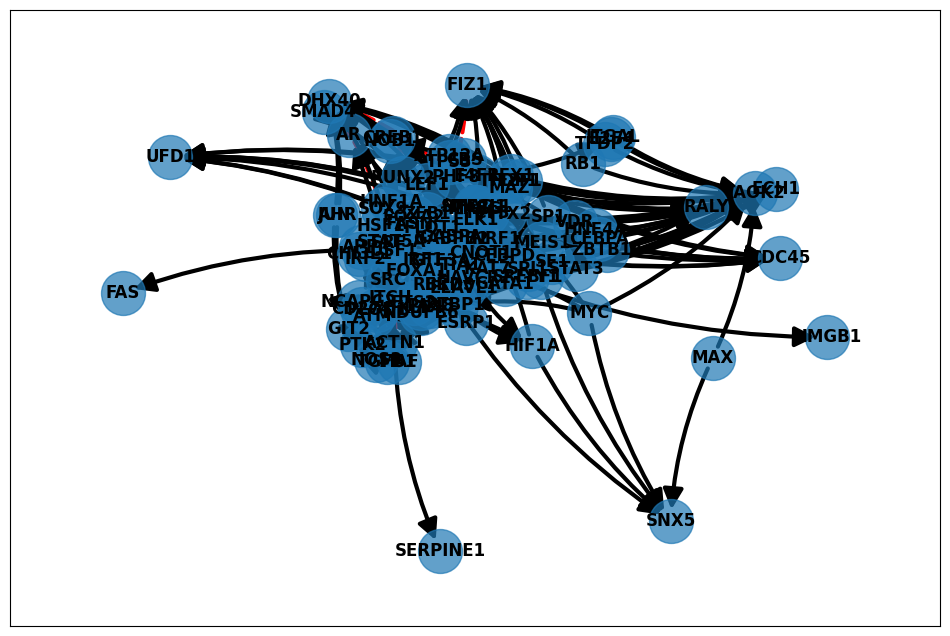

In [12]:
cnagwt_dag = GraphBuilder(cnagwt, df, False)

cnagwt_dag.build_full_graph(data_type="LF",
                        protein_format=None,
                        source_name="source_hgnc_symbol",
                        target_name="target_hgnc_symbol")
cnagwt_dag.build_dag()
cnagwt_dag.create_latent_graph()
cnagwt_dag.plot_latent_graph(figure_size=(12, 8))

In [13]:
lvm = LVM(cnagwt_dag.experimental_data.reset_index(drop=True), 
          cnagwt_dag.causal_graph)
lvm.prepare_graph()
lvm.prepare_data()

lvm.fit_model(num_steps=2000)

starting training
114038.18109815125
22109.791729807854
-5228.4126735553145
-16673.961994104087
-22950.98626416549
-27073.53801844269
-30080.940824747086
-32070.08794531226
-33600.70315722376
-35021.09667599946
-36017.0557251852
-36773.8510894347
-37195.66630916111
-37904.4078671094
-38295.311128336936
-38377.00747893937
-39045.80512184277
-38989.16302820295
-39053.8605546169
-39286.20788029209


In [18]:
from y0.dsl import P, Variable
import networkx as nx
[i for i in nx.all_simple_paths(cnagwt_dag.causal_graph.directed, Variable("BRD3"), Variable("TIA1"))]

[]

In [25]:
lvm.intervention("obs_BRD3", "KAT7", 3.)

<Axes: >

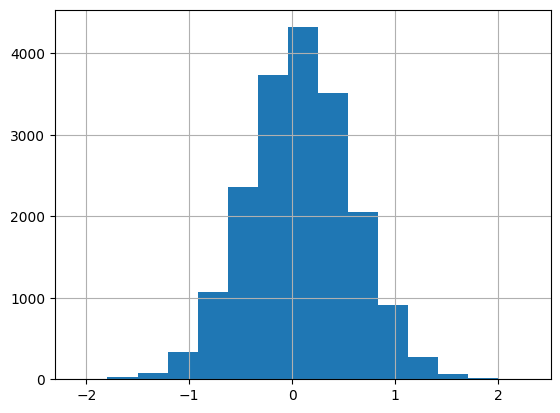

In [27]:
pd.Series(lvm.intervention_samples).hist(bins=15)

In [19]:
cnagwt_dag.causal_graph.directed.out_edges(Variable("BRD3"))

OutEdgeDataView([(BRD3, CD274), (BRD3, CEBPD), (BRD3, GATA1), (BRD3, KAT7)])

In [23]:
lvm.parameters[lvm.parameters["parameter"].str.contains("KAT7")]

,parameter,mean,scale
232,KAT7_intercept,-0.020195918,0.01753364
233,KAT7_USF1_coef,0.06589696,0.027601507
234,KAT7_CEBPA_coef,0.020091107,0.009814051
235,KAT7_SREBF1_coef,0.07375661,0.031189205
236,KAT7_BRD3_coef,0.041831356,0.026860835
237,KAT7_GATA1_coef,-0.026199277,0.012855779
238,KAT7_CNOT1_coef,0.22948417,0.04297726
239,KAT7_PHF8_coef,0.30612695,0.032638144
240,KAT7_E4F1_coef,0.041815646,0.025484886
241,KAT7_PTBP1_coef,0.26128024,0.056113835


In [22]:
cnagwt_dag.causal_graph.directed.out_edges(Variable("GATA1"))

OutEdgeDataView([(GATA1, KAT7)])